In [1]:
!git clone https://github.com/Diego999/pyGAT.git

Cloning into 'pyGAT'...
remote: Enumerating objects: 107, done.
remote: Total 107 (delta 0), reused 0 (delta 0), pack-reused 107
Receiving objects: 100% (107/107), 202.66 KiB | 2.23 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [1]:
cd pyGAT

/content/pyGAT


In [2]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.4.1
True


In [0]:
import numpy as np
import scipy.sparse as sp

path="./data/cora/" 
dataset="cora"
idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset), dtype=np.dtype(str))
features = idx_features_labels[:, 1:-1].astype(bool)

In [0]:
import torch


def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot
    
labels = encode_onehot(idx_features_labels[:, -1])


idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
idx_map = {j: i for i, j in enumerate(idx)}
edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset), dtype=np.int32)
edges = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32).reshape(edges_unordered.shape)
adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), shape=(labels.shape[0], labels.shape[0]), dtype=np.float32)


In [0]:
idx_test = range(500, 1500)
features[idx_test].shape

(1000, 1433)

In [0]:
def log_uniform(r, min_val, max_val):
    point = 0
    if (r <= 0):
        point = -1.0
    else:
        log_min_val = np.log10(min_val)
        log_max_val = np.log10(max_val)
        point = 10.0 ** (log_min_val + r * (log_max_val - log_min_val))
    return point

In [0]:
from __future__ import division
from __future__ import print_function

import os
import glob
import time
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from utils import load_data, accuracy
from models import GAT, SpGAT

# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=True, help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False, help='Validate during training pass.')
parser.add_argument('--sparse', action='store_true', default=True, help='GAT with sparse version or not.')
parser.add_argument('--seed', type=int, default=72, help='Random seed.')
parser.add_argument('--epochs', type=int, default=100, help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.005, help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4, help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=8, help='Number of hidden units.')
parser.add_argument('--nb_heads', type=int, default=8, help='Number of head attentions.')
parser.add_argument('--dropout', type=float, default=0.6, help='Dropout rate (1 - keep probability).')
parser.add_argument('--alpha', type=float, default=0.2, help='Alpha for the leaky_relu.')
parser.add_argument('--patience', type=int, default=100, help='Patience')
parser.add_argument('--add_noise', type=float, default=0.0, help='noise level to add to test set')


args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Load data
adj, features, labels, idx_train, idx_val, idx_test = load_data(noise_level_test = args.add_noise)

# Model and optimizer
if args.sparse:
    model = SpGAT(nfeat=features.shape[1], 
                nhid=args.hidden, 
                nclass=int(labels.max()) + 1, 
                dropout=args.dropout, 
                nheads=args.nb_heads, 
                alpha=args.alpha)
else:
    model = GAT(nfeat=features.shape[1], 
                nhid=args.hidden, 
                nclass=int(labels.max()) + 1, 
                dropout=args.dropout, 
                nheads=args.nb_heads, 
                alpha=args.alpha)
optimizer = optim.Adam(model.parameters(), 
                       lr=args.lr, 
                       weight_decay=args.weight_decay)

if args.cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

features, adj, labels = Variable(features), Variable(adj), Variable(labels)


def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    if not args.fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        model.eval()
        output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.data.item()),
          'acc_train: {:.4f}'.format(acc_train.data.item()),
          'loss_val: {:.4f}'.format(loss_val.data.item()),
          'acc_val: {:.4f}'.format(acc_val.data.item()),
          'time: {:.4f}s'.format(time.time() - t))

    return loss_val.data.item()



def compute_test():
    model.eval()
    output = model(features, adj)
    print('now adding noise to test data')
    #output = add_noise(output, eps=0.1)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.data[0]),
          "accuracy= {:.4f}".format(acc_test.data[0]))

# Train model
t_total = time.time()
loss_values = []
bad_counter = 0
best = args.epochs + 1
best_epoch = 0
for epoch in range(args.epochs):
    loss_values.append(train(epoch))

    torch.save(model.state_dict(), '{}.pkl'.format(epoch))
    if loss_values[-1] < best:
        best = loss_values[-1]
        best_epoch = epoch
        bad_counter = 0
    else:
        bad_counter += 1

    if bad_counter == args.patience:
        break

    files = glob.glob('*.pkl')
    for file in files:
        epoch_nb = int(file.split('.')[0])
        if epoch_nb < best_epoch:
            os.remove(file)

files = glob.glob('*.pkl')
for file in files:
    epoch_nb = int(file.split('.')[0])
    if epoch_nb > best_epoch:
        os.remove(file)

print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Restore best model
print('Loading {}th epoch'.format(best_epoch))
model.load_state_dict(torch.load('{}.pkl'.format(best_epoch)))

# Testing
compute_test()

In [6]:
from __future__ import division
from __future__ import print_function

import os
import glob
import time
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from utils import load_data, accuracy
from models import GAT, SpGAT





def compute_test(noise_level):

    acc = []
    loss = []

    for n in noise_level:
        print(n)
        # Load data with noise
        print('now adding eps = ', n)
        adj, features, labels, idx_train, idx_val, idx_test = load_data(noise_level_test = n)
        
        model.cuda()
        features = features.cuda()
        adj = adj.cuda()
        labels = labels.cuda()
        idx_train = idx_train.cuda()
        idx_val = idx_val.cuda()
        idx_test = idx_test.cuda()
            
        features, adj, labels = Variable(features), Variable(adj), Variable(labels)

        # model = SpGAT(nfeat=features.shape[1], 
        #               nhid=8, 
        #               nclass=int(labels.max()) + 1, 
        #               dropout=0.6, 
        #               nheads=8, 
        #               alpha=0.2)



        # Restore best model
        best_epoch = 99
        print('Loading {}th epoch'.format(best_epoch))
        model.load_state_dict(torch.load('{}.pkl'.format(best_epoch)))


        model.eval()
        output = model(features, adj)

        #output = add_noise(output, eps=0.1)
        loss_test = F.nll_loss(output[idx_test], labels[idx_test])
        acc_test = accuracy(output[idx_test], labels[idx_test])
        print("Test set results for eps = ", n, ' : ',
              "loss= {:.4f}".format(loss_test.data[0]),
              "accuracy= {:.4f}".format(acc_test.data[0]))
        
        loss.append(loss_test.data[0])
        acc.append(acc_test.data[0])

    return loss,acc
    

# Testing

noise_level = np.linspace(0, 0.9, num=20)

loss,acc = compute_test(noise_level)



0.0
now adding eps =  0.0
Loading cora datasetss...
Loading 99th epoch
Test set results for eps =  0.0  :  loss= 1.0747 accuracy= 0.8280
0.04736842105263158
now adding eps =  0.04736842105263158
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 99th epoch
Test set results for eps =  0.04736842105263158  :  loss= 1.4442 accuracy= 0.7670
0.09473684210526316
now adding eps =  0.09473684210526316
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 99th epoch
Test set results for eps =  0.09473684210526316  :  loss= 1.4930 accuracy= 0.7510
0.14210526315789473
now adding eps =  0.14210526315789473
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 99th epoch
Test set results for eps =  0.14210526315789473  :  loss= 1.5142 accuracy= 0.7320
0.18947368421052632
now adding eps =  0.18947368421052632
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 99th epoch
Test set results for eps =  0.18947368421052632  :  loss= 1.5272 accuracy= 0.7120
0.2368421052631579
now adding eps =  0.2368421052631579
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 99th epoch
Test set results for eps =  0.2368421052631579  :  loss= 1.5338 accuracy= 0.7110
0.28421052631578947
now adding eps =  0.28421052631578947
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 99th epoch
Test set results for eps =  0.28421052631578947  :  loss= 1.5360 accuracy= 0.7070
0.3315789473684211
now adding eps =  0.3315789473684211
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 99th epoch
Test set results for eps =  0.3315789473684211  :  loss= 1.5400 accuracy= 0.7060
0.37894736842105264
now adding eps =  0.37894736842105264
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 99th epoch
Test set results for eps =  0.37894736842105264  :  loss= 1.5429 accuracy= 0.6970
0.4263157894736842
now adding eps =  0.4263157894736842
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 99th epoch
Test set results for eps =  0.4263157894736842  :  loss= 1.5450 accuracy= 0.6980
0.4736842105263158
now adding eps =  0.4736842105263158
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 99th epoch
Test set results for eps =  0.4736842105263158  :  loss= 1.5446 accuracy= 0.6970
0.5210526315789474
now adding eps =  0.5210526315789474
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 99th epoch
Test set results for eps =  0.5210526315789474  :  loss= 1.5477 accuracy= 0.6940
0.5684210526315789
now adding eps =  0.5684210526315789
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 99th epoch
Test set results for eps =  0.5684210526315789  :  loss= 1.5489 accuracy= 0.6950
0.6157894736842106
now adding eps =  0.6157894736842106
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 99th epoch
Test set results for eps =  0.6157894736842106  :  loss= 1.5497 accuracy= 0.6900
0.6631578947368422
now adding eps =  0.6631578947368422
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 99th epoch
Test set results for eps =  0.6631578947368422  :  loss= 1.5508 accuracy= 0.6920
0.7105263157894737
now adding eps =  0.7105263157894737
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 99th epoch
Test set results for eps =  0.7105263157894737  :  loss= 1.5516 accuracy= 0.6920
0.7578947368421053
now adding eps =  0.7578947368421053
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 99th epoch
Test set results for eps =  0.7578947368421053  :  loss= 1.5516 accuracy= 0.6980
0.8052631578947369
now adding eps =  0.8052631578947369
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 99th epoch
Test set results for eps =  0.8052631578947369  :  loss= 1.5525 accuracy= 0.6900
0.8526315789473684
now adding eps =  0.8526315789473684
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 99th epoch
Test set results for eps =  0.8526315789473684  :  loss= 1.5530 accuracy= 0.6900
0.9
now adding eps =  0.9
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 99th epoch
Test set results for eps =  0.9  :  loss= 1.5531 accuracy= 0.6910


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


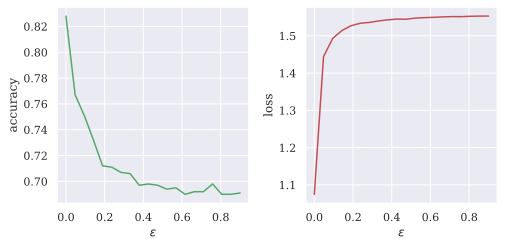

In [8]:
plt.subplot(121)
plt.plot(noise_level, acc, 'g')
#plt.xscale('log')
format_plot(x=r'$\epsilon$', y='accuracy')

plt.subplot(122)
plt.plot(noise_level, loss, 'r')

format_plot(x=r'$\epsilon$', y='loss')
finalize_plot(shape=(1.2, 0.6))
plt.savefig('acc-loss.pdf')

In [42]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib
import seaborn as sns

import functools

  
sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
sns.set(font='serif')

import matplotlib.pyplot as plt

def format_plot(x=None, y=None): 
  # plt.grid(False)
  ax = plt.gca()
  if x is not None:
    plt.xlabel(x, fontsize=12)
  if y is not None:
    plt.ylabel(y, fontsize=12)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

legend = functools.partial(plt.legend, fontsize=10)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [44]:
# Now train with noise

from __future__ import division
from __future__ import print_function

import os
import glob
import time
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import scipy.sparse as sp


from utils import load_data, accuracy
from models import GAT, SpGAT

# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=True, help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False, help='Validate during training pass.')
parser.add_argument('--sparse', action='store_true', default=True, help='GAT with sparse version or not.')
parser.add_argument('--seed', type=int, default=72, help='Random seed.')
parser.add_argument('--epochs', type=int, default=250, help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.005, help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4, help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=8, help='Number of hidden units.')
parser.add_argument('--nb_heads', type=int, default=8, help='Number of head attentions.')
parser.add_argument('--dropout', type=float, default=0.6, help='Dropout rate (1 - keep probability).')
parser.add_argument('--alpha', type=float, default=0.2, help='Alpha for the leaky_relu.')
parser.add_argument('--patience', type=int, default=100, help='Patience')
parser.add_argument('--add_noise', type=float, default=0.0, help='noise level to add to test set')


args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)




# Model and optimizer
if args.sparse:
    model = SpGAT(nfeat=features.shape[1], 
                nhid=args.hidden, 
                nclass=int(labels.max()) + 1, 
                dropout=args.dropout, 
                nheads=args.nb_heads, 
                alpha=args.alpha)
else:
    model = GAT(nfeat=features.shape[1], 
                nhid=args.hidden, 
                nclass=int(labels.max()) + 1, 
                dropout=args.dropout, 
                nheads=args.nb_heads, 
                alpha=args.alpha)
optimizer = optim.Adam(model.parameters(), 
                       lr=args.lr, 
                       weight_decay=args.weight_decay)

if args.cuda:
    model.cuda()







def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    if not args.fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        model.eval()
        output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.data.item()),
          'acc_train: {:.4f}'.format(acc_train.data.item()),
          'loss_val: {:.4f}'.format(loss_val.data.item()),
          'acc_val: {:.4f}'.format(acc_val.data.item()),
          'time: {:.4f}s'.format(time.time() - t))

    return loss_val.data.item()


def compute_test():
    model.eval()
    output = model(features, adj)

    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.data[0]),
          "accuracy= {:.4f}".format(acc_test.data[0]))

# Train model
t_total = time.time()
loss_values = []
bad_counter = 0
best = args.epochs + 1
best_epoch = 0
for epoch in range(args.epochs):

    # re-generate noisy data
    r = np.random.rand()
    noise_level_train = log_uniform(r, 0.05, 0.6)


    # Load data
    adj, features, labels, idx_train, idx_val, idx_test = load_data(noise_level_test = args.add_noise)
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

    features, adj, labels = Variable(features), Variable(adj), Variable(labels)


    loss_values.append(train(epoch))

    torch.save(model.state_dict(), '{}.pkl'.format(epoch))
    if loss_values[-1] < best:
        best = loss_values[-1]
        best_epoch = epoch
        bad_counter = 0
    else:
        bad_counter += 1

    if bad_counter == args.patience:
        break

    files = glob.glob('*.pkl')
    for file in files:
        epoch_nb = int(file.split('.')[0])
        if epoch_nb < best_epoch:
            os.remove(file)

files = glob.glob('*.pkl')
for file in files:
    epoch_nb = int(file.split('.')[0])
    if epoch_nb > best_epoch:
        os.remove(file)

print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Restore best model
print('Loading {}th epoch'.format(best_epoch))
model.load_state_dict(torch.load('{}.pkl'.format(best_epoch)))

# Testing
compute_test()

Loading cora datasetss...
Epoch: 0001 loss_train: 1.9518 acc_train: 0.0714 loss_val: 1.9389 acc_val: 0.3000 time: 0.2606s
Loading cora datasetss...
Epoch: 0002 loss_train: 1.9412 acc_train: 0.1857 loss_val: 1.9305 acc_val: 0.4500 time: 0.2619s
Loading cora datasetss...
Epoch: 0003 loss_train: 1.9305 acc_train: 0.2500 loss_val: 1.9223 acc_val: 0.4933 time: 0.2452s
Loading cora datasetss...
Epoch: 0004 loss_train: 1.9154 acc_train: 0.3857 loss_val: 1.9139 acc_val: 0.5167 time: 0.2296s
Loading cora datasetss...
Epoch: 0005 loss_train: 1.9090 acc_train: 0.3857 loss_val: 1.9054 acc_val: 0.5267 time: 0.2181s
Loading cora datasetss...
Epoch: 0006 loss_train: 1.8994 acc_train: 0.4500 loss_val: 1.8969 acc_val: 0.5300 time: 0.2119s
Loading cora datasetss...
Epoch: 0007 loss_train: 1.8880 acc_train: 0.4929 loss_val: 1.8884 acc_val: 0.5300 time: 0.2076s
Loading cora datasetss...
Epoch: 0008 loss_train: 1.8778 acc_train: 0.4714 loss_val: 1.8797 acc_val: 0.5400 time: 0.2065s
Loading cora datasetss..

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [46]:
from __future__ import division
from __future__ import print_function

import os
import glob
import time
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from utils import load_data, accuracy
from models import GAT, SpGAT





def compute_test(noise_level):

    acc = []
    loss = []

    for n in noise_level:
        print(n)
        # Load data with noise
        print('now adding eps = ', n)
        adj, features, labels, idx_train, idx_val, idx_test = load_data(noise_level_test = n)
        
        model.cuda()
        features = features.cuda()
        adj = adj.cuda()
        labels = labels.cuda()
        idx_train = idx_train.cuda()
        idx_val = idx_val.cuda()
        idx_test = idx_test.cuda()
            
        features, adj, labels = Variable(features), Variable(adj), Variable(labels)

        # model = SpGAT(nfeat=features.shape[1], 
        #               nhid=8, 
        #               nclass=int(labels.max()) + 1, 
        #               dropout=0.6, 
        #               nheads=8, 
        #               alpha=0.2)



        # Restore best model
        best_epoch = 249
        print('Loading {}th epoch'.format(best_epoch))
        model.load_state_dict(torch.load('{}.pkl'.format(best_epoch)))


        model.eval()
        output = model(features, adj)

        #output = add_noise(output, eps=0.1)
        loss_test = F.nll_loss(output[idx_test], labels[idx_test])
        acc_test = accuracy(output[idx_test], labels[idx_test])
        print("Test set results for eps = ", n, ' : ',
              "loss= {:.4f}".format(loss_test.data[0]),
              "accuracy= {:.4f}".format(acc_test.data[0]))
        
        loss.append(loss_test.data[0])
        acc.append(acc_test.data[0])

    return loss,acc
    

# Testing

noise_level = np.linspace(0, 0.9, num=20)

loss,acc = compute_test(noise_level)



0.0
now adding eps =  0.0
Loading cora datasetss...
Loading 249th epoch
Test set results for eps =  0.0  :  loss= 0.7448 accuracy= 0.8380
0.04736842105263158
now adding eps =  0.04736842105263158
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 249th epoch
Test set results for eps =  0.04736842105263158  :  loss= 1.1961 accuracy= 0.7800
0.09473684210526316
now adding eps =  0.09473684210526316
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 249th epoch
Test set results for eps =  0.09473684210526316  :  loss= 1.2697 accuracy= 0.7480
0.14210526315789473
now adding eps =  0.14210526315789473
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 249th epoch
Test set results for eps =  0.14210526315789473  :  loss= 1.2972 accuracy= 0.7450
0.18947368421052632
now adding eps =  0.18947368421052632
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 249th epoch
Test set results for eps =  0.18947368421052632  :  loss= 1.3161 accuracy= 0.7430
0.2368421052631579
now adding eps =  0.2368421052631579
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 249th epoch
Test set results for eps =  0.2368421052631579  :  loss= 1.3243 accuracy= 0.7280
0.28421052631578947
now adding eps =  0.28421052631578947
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 249th epoch
Test set results for eps =  0.28421052631578947  :  loss= 1.3318 accuracy= 0.7290
0.3315789473684211
now adding eps =  0.3315789473684211
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 249th epoch
Test set results for eps =  0.3315789473684211  :  loss= 1.3371 accuracy= 0.7250
0.37894736842105264
now adding eps =  0.37894736842105264
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 249th epoch
Test set results for eps =  0.37894736842105264  :  loss= 1.3432 accuracy= 0.7180
0.4263157894736842
now adding eps =  0.4263157894736842
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 249th epoch
Test set results for eps =  0.4263157894736842  :  loss= 1.3470 accuracy= 0.7210
0.4736842105263158
now adding eps =  0.4736842105263158
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 249th epoch
Test set results for eps =  0.4736842105263158  :  loss= 1.3470 accuracy= 0.7230
0.5210526315789474
now adding eps =  0.5210526315789474
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 249th epoch
Test set results for eps =  0.5210526315789474  :  loss= 1.3494 accuracy= 0.7200
0.5684210526315789
now adding eps =  0.5684210526315789
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 249th epoch
Test set results for eps =  0.5684210526315789  :  loss= 1.3512 accuracy= 0.7190
0.6157894736842106
now adding eps =  0.6157894736842106
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 249th epoch
Test set results for eps =  0.6157894736842106  :  loss= 1.3536 accuracy= 0.7140
0.6631578947368422
now adding eps =  0.6631578947368422
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 249th epoch
Test set results for eps =  0.6631578947368422  :  loss= 1.3554 accuracy= 0.7160
0.7105263157894737
now adding eps =  0.7105263157894737
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 249th epoch
Test set results for eps =  0.7105263157894737  :  loss= 1.3552 accuracy= 0.7160
0.7578947368421053
now adding eps =  0.7578947368421053
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 249th epoch
Test set results for eps =  0.7578947368421053  :  loss= 1.3567 accuracy= 0.7170
0.8052631578947369
now adding eps =  0.8052631578947369
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 249th epoch
Test set results for eps =  0.8052631578947369  :  loss= 1.3574 accuracy= 0.7160
0.8526315789473684
now adding eps =  0.8526315789473684
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 249th epoch
Test set results for eps =  0.8526315789473684  :  loss= 1.3578 accuracy= 0.7130
0.9
now adding eps =  0.9
Loading cora datasetss...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loading 249th epoch
Test set results for eps =  0.9  :  loss= 1.3590 accuracy= 0.7140


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


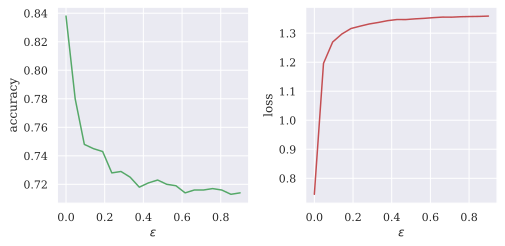

In [47]:
plt.subplot(121)
plt.plot(noise_level, acc, 'g')
#plt.xscale('log')
format_plot(x=r'$\epsilon$', y='accuracy')

plt.subplot(122)
plt.plot(noise_level, loss, 'r')

format_plot(x=r'$\epsilon$', y='loss')
finalize_plot(shape=(1.2, 0.6))
plt.savefig('acc-loss-trained-with-noise.pdf')